In [1]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

# Vocabulary class

In [2]:
class Vocabulary(object):
    """
    Класс, предназначенный для обработки текста и извлечения значений токенов
    """
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): pre-existing map of tokens to indices
            add_unk (bool): flag that indicates whether add the UNK token
            unk_token (str): UNK token to add in Vocab
        """
        if token_to_idx is None:
            token_to_idx = dict()
        self._token_to_idx = token_to_idx
        self._idx_to_token = {
            idx: token 
            for token, idx in self._token_to_idx.items()
        }
        self._add_unk = add_unk
        self._unk_token = unk_token
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token)
            
    def to_serializable(self):
        """ возвращает словарь с возможностью сериализации """
        return {
            'token_to_idx': self._token_to_idx,
            'add_unk': self._add_unk,
            'unk_token': self._unk_token
        }
    @classmethod
    def from_serializable(cls, contents):
        """ создает экземпляр класса Vocabulary из сериализованного словаря """
        return cls(**contents)
    
    def add_token(self, token):
        """ Добавляет токен в словари, возвращая его индекс
        
        Args:
            token (str): токен, добавляемый в Vocabulary
        Returns:
            index (int): индекс токена в словарях
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        """Добавляет список токенов в словарь
        
        Args:
            tokens (list): список токенов типа string
        Returns:
            indices (list): список индексов, соответствующих списку токенов
        """
        return [self.add_token for token in tokens]
    
    def lookup_token(self, token):
        """Возвращает число, соответствующее токену или индекс элемента UNK.
        
        Args:
            token (str): токен
        Returns:
            index (int): индекс, соответствующий токену
        Notes:
            `unk_index` должен быть >=0 (добавлен в словарь) 
              для функционирования UNK
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]
        
    def lookup_index(self, index):
        """
        """
        if index not in self._idx_to_token:
            raise KeyError(f"The index {index} is not in Vocabulary")
        return self._idx_to_token[index]
    
    def __str__(self):
        return f"Vocabulary(size={len(self)})"
    
    def __len__(self):
        return len(self._token_to_idx)
    

# Vectorizer class

In [3]:
class Vectorizer(object):
    """ Класс, координирующий Vocabularies и использует их
    """
    def __init__(self, review_vocab, rating_vocab):
        """
        Args:
            review_vocab (Vocabulary): токены - цифры
            rating_vocab (Vocabulary): метки классов - цифры
        """
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab
        
    def vectorize(self, review):
        """Создает вектор для обзора
        Args:
            review (str): обзор
        Returns:
            one_hot (np.ndarray): one-hot вектор
        """
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
        
        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1
        return one_hot
    
    @classmethod
    def from_dataframe(cls, review_df, cutoff=25):
        """Инициализирует Vectorizer из pandas.DataFrame
        
        Args:
            review_df (pandas.DataFrame): датасет обзоров
            cutoff (int): параметр для отсеивания по частоте
        Returns:
            Экземпляр Vectorizer
        """        
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)
        
        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)
            
        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)
        return cls(review_vocab, rating_vocab)
    
    @classmethod
    def from_serializable(cls, contents):
        """Инициализирует Vectorizer из сериализованного словаря
        Args:
            contents (dict): сериализованный словарь
        Returns:
            Экземпляр Vectorizer
        """
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab = Vocabulary.from_serializable(contents['rating_vocab'])
        
        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)
    
    def to_serializable(self):
        """Создает сериализованный словарь на основе класса Vectorizer
        """
        return {
            'review_vocab': self.review_vocab.to_serializable(),
            'rating_vocab': self.rating_vocab.to_serializable()
        }

# Dataset

In [4]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        """
        Args:
            review_df (pandas.DataFrame): Датасет
            vectorizer (Vectorizer): Vectorizer, созданный из датасета
        """
        self.review_df = review_df
        self._vectorizer = vectorizer
        
        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)
        
        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)
        
        self.val_df = self.review_df[self.review_df.split=='val']
        self.val_size = len(self.val_df)
        
        self._lookup_dict = {
            'train': (self.train_df, self.train_size),
            'val': (self.val_df, self.val_size),
            'test': (self.test_df, self.test_size)
        }
        self.set_split('train')
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        """Загружает датасет из пути review_csv и создает для него Vectorizer
        Args:
            review_csv (str): путь к данным
        Returns:
            Экземпляр ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, Vectorizer.from_dataframe(train_review_df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        """Загружает датасет из пути review_csv и Vectorizer из пути vectorizer_filepath
        Используется в случае если Vectorizer был закеширован
        Args:
            review_csv (str): путь к данным
            vectorizer_filepath (str): путь к Vectorizer
        Returns:
            Экземпляр ReviewDataset
        """
        review_df = pd.read_csv(review_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(review_df, vectorizer)
    
    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """Загружает Vectorizer из vectorizer_filepath
        Args:
            vectorizer_filepath (str): путь к Vectorizer
        Returns:
            Экземпляр Vectorizer
        """
        with open(vectorizer_filepath) as fp:
            return Vectorizer.from_serializable(json.load(fp))
    
    def save_vectorizer(self, vectorizer_filepath):
        """Сохраняет Vectorizer в json
        
        Args:
            vectorizer_filepath (str): путь, куда сохранять
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)
            
    def get_vectorizer(self):
        """ Возвращает Vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        """Выбирает разбиение, используя колонку split в dataframe
        
        Args:
            split (str): одно из "train", "val", or "test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]
        
    def __len__(self):
        """ Для PyTorch, возвращает длину датасета """
        return self._target_size
    
    def __getitem__(self, index):
        """ Для PyTorch, возвращает строку по индексу
        Args:
            index (int): индекс строки данных 
        Returns:
            словарь, содержащий фичи (x_data) и метку (y_target)
        """
        row = self._target_df.iloc[index]
        review_vector = self._vectorizer.vectorize(row.review)
        rating_index = self._vectorizer.rating_vocab.lookup_token(row.rating)
        return {
            'x_data': review_vector,
            'y_target': rating_index
        }
    def get_num_batches(self, batch_size):
        """ Возврращает количество батчей при заданном batch_size
        Args:
            batch_size (int): размер батча
        Returns:
            количество батчей в датасете
        """
        return len(self) // batch_size
    
def generate_batches(
    dataset, 
    batch_size,
    shuffle=True,
    drop_last=True,
    device="cpu"
):
    """Генератор, использующий PyTorch DataLoader.
    Позволяет быть уверенным, что данные будут на одном девайсе.
    """
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last
    )
    for data_dict in dataloader:
        out_data_dict = dict()
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

# Model

In [5]:
class ReviewClassifier(nn.Module):
    """ Simple Perceptron classifier """
    def __init__(self, num_features):
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, out_features=1)
    
    def forward(self, x_in, apply_sigmoid=False):
        y_out = self.fc1(x_in).squeeze()
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out

# Other usefull functions

In [6]:
def make_train_state(args):
    return {
        'stop_early': False,
        'early_stopping_step': 0,
        'early_stopping_best_val': 1e8,
        'learning_rate': args.learning_rate,
        'epoch_index': 0,
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'test_loss': -1,
        'test_acc': -1,
        'model_filename': args.model_state_file
    }

def update_train_state(args, model, train_state):
    # save model at first epoch
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False
    # if th epoch is not first, update model if results are better
    elif train_state['epoch_index'] > 0:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
        #if loss got worse
        if loss_t >= train_state['early_stopping_best_val']:
            train_state['early_stopping_step'] += 1
        else:
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
            
            train_state['early_stopping_step'] = 0
            
        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria
        
    return train_state

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred) > 0.5).cpu().long()
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

# Classification

In [7]:
args = Namespace(
    # Data params
    frequency_cutoff=25,
    model_state_file='model.pth',
    review_csv='../data/yelp/reviews_with_splits_lite.csv',
    save_dir='../model_storage/ch3/yelp',
    vectorizer_file='vectorizer.json',
    # Model params
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=1e-3,
    num_epochs=100,
    seed=1337,
    # Runtime params
    catch_keybord_interrupt=True,
    cuda=False,
    expand_files_to_save_dir=True,
    reload_from_files=False
)

if args.expand_files_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir, args.vectorizer_file)
    args.model_state_file = os.path.join(args.save_dir, args.model_state_file)
    print(f"Expanded filepaths \n {args.vectorizer_file} \n {args.model_state_file}")
    
if not torch.cuda.is_available():
    args.cuda = False
    
print(f"Using CUDA? -> {args.cuda}")

args.device = torch.device("cuda" if args.cuda else "cpu")

set_seed_everywhere(args.seed, args.cuda)

handle_dirs(args.save_dir)

Expanded filepaths 
 ../model_storage/ch3/yelp\vectorizer.json 
 ../model_storage/ch3/yelp\model.pth
Using CUDA? -> False


In [8]:
# Initializings
if args.reload_from_files:
    print("Loading dataset and vectorizer")
    dataset = ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv, args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
    dataset.save_vectorizer(args.vectorizer_file)
vectorizer = dataset.get_vectorizer()

classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab))

Loading dataset and creating vectorizer


In [9]:
# training loop
train_state = make_train_state(args)
classifier = classifier.to(args.device)
loss_func = nn.BCEWithLogitsLoss()
optimizer = opt.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = opt.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, 
    mode='min', 
    factor=0.5, 
    patience=1
)
epoch_bar = tqdm(
    desc='training_routine',
    total = args.num_epochs,
    position=0           
)

dataset.set_split('train')
train_bar = tqdm(
    desc='split_train',
    total = dataset.get_num_batches(args.batch_size),
    position=1,
    leave=True
)
dataset.set_split('val')
val_bar = tqdm(
    desc='split_val',
    total = dataset.get_num_batches(args.batch_size),
    position=1,
    leave=True
)
try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index
        
        dataset.set_split('train')
        batch_generator = generate_batches(
            dataset,
            batch_size=args.batch_size,
            device=args.device
        )
        running_loss = 0.0 # сдесь используется формула скользящего среднего для отслеживания плато
        running_acc = 0.0
        classifier.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # main train loop
            
            # step 1: zero grads
            optimizer.zero_grad()
            
            # step 2: compute output
            y_pred = classifier(x_in=batch_dict['x_data'].float())
            
            # step 3: compute loss
            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)
            
            # step 4: backprop
            loss.backward()
            
            #step 5: opimizer step
            optimizer.step()
            
            # Additional stuff
            # accuracy  
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            #update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()
            
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)
        
        # now with validation
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, batch_size=args.batch_size, device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.eval()
        for batch_index, batch_dict in enumerate(batch_generator):
            y_pred = classifier(x_in=batch_dict['x_data']).float()
            loss_t = loss_func(y_pred, batch_dict['y_target'].float()).item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()
            
        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        
        train_state = update_train_state(args=args, model=classifier, train_state=train_state)
        
        scheduler.step(train_state['val_loss'][-1])
        
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
        
        if train_state['stop_early']:
            break
            
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Key exiting loop")

training_routine:   0%|          | 0/100 [00:00<?, ?it/s]

split_train:   0%|          | 0/306 [00:00<?, ?it/s]

split_val:   0%|          | 0/65 [00:00<?, ?it/s]

Key exiting loop


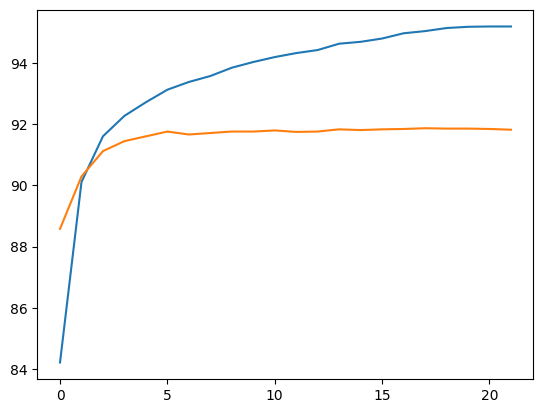

In [13]:
import matplotlib.pyplot as plt
plt.plot(train_state['train_acc'])
plt.plot(train_state['val_acc'])

# Testing model

In [15]:
classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, args.batch_size, device=args.device)

running_loss = 0.0
running_acc = 0.0
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    y_pred = classifier(x_in=batch_dict['x_data'].float())
    
    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)
    
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'].float())
    running_acc += (acc_t - running_acc) / (batch_index + 1)
    
train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [16]:
print(f"Test loss = {train_state['test_loss']}")
print(f"Test acc = {train_state['test_acc']}")

Test loss = 0.20353888479562907
Test acc = 92.23557692307689


In [17]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [20]:
def predict_rating(review, classifier, vectorizer, decision_threshold=0.5):
    review = preprocess_text(review)
    
    vectorized_review = torch.Tensor(vectorizer.vectorize(review))
    result = classifier(vectorized_review.view(1, -1))
    
    probability_value = torch.sigmoid(result).item()
    index = 1
    if probability_value < decision_threshold:
        index = 0
    return vectorizer.rating_vocab.lookup_index(index)

In [34]:
test_review = "this is a pretty yum book"

classifier = classifier.cpu()
prediction = predict_rating(test_review, classifier, vectorizer, decision_threshold=0.5)
print(f"Rewiew '{test_review}' is {prediction}")

Rewiew 'this is a pretty yum book' is positive


In [26]:
classifier.fc1.weight.shape

torch.Size([1, 7326])

In [28]:
fc1_weights = classifier.fc1.weight.detach()[0]
_, indices = torch.sort(fc1_weights, dim=0, descending=True)
indices = indices.numpy().tolist()

print("Influential positive words")
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))
    
print()
print("Influential negative words")
indices.reverse()
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))

Influential positive words
delicious
fantastic
amazing
pleasantly
great
vegas
excellent
yum
awesome
perfect
yummy
ngreat
love
bomb
solid
wonderful
pleased
notch
reasonable
perfection

Influential negative words
worst
mediocre
bland
horrible
meh
awful
rude
terrible
tasteless
overpriced
disgusting
poorly
unacceptable
unfriendly
slowest
disappointing
nmaybe
disappointment
downhill
elsewhere
